In [7]:
import jax
jax.config.update("jax_enable_x64", True)
import s2fft
import healpy as hp
import numpy as np
import s2wav
import s2wav.filters as filters
import matplotlib.pyplot as plt
import os
from astropy.io import fits #For beam deconvolution



# Convert arcminutes to radians
def arcmin_to_radians(arcmin):
    return np.radians(arcmin / 60)

# Read maps
def read_healpix_map(CMB_map_path, frequency, plot = False):
    original_healpix_map = hp.read_map(CMB_map_path)
    if frequency == "545":
        original_healpix_map = original_healpix_map/58.0356
    if frequency == "857":
        original_healpix_map = original_healpix_map/2.2681
    
    if plot:
        hp.mollview(
            original_healpix_map,
            coord=["G"],
            title="Full Sky CMB",
            unit=r"$μ$K",
            # min=-300,
            # max=300,
        )
        plt.show()
    return original_healpix_map

def process_and_save_all_maps(frequencies, realizations, lmax, directory="CMB_realizations"):
    """
    Processes and saves the CMB, Synchrotron, and Noise maps for all specified
    frequencies and realizations, then combines them.
    
    Args:
        frequencies (list): List of frequency identifiers.
        realizations (list): List of realization identifiers.
        lmax (int): Maximum multipole moment for spherical harmonics.
        directory (str): Directory containing the input map files.
    """
    for frequency in frequencies:
        for realization in realizations:

            cmb_file = f"{directory}/febecop_ffp10_lensed_scl_cmb_{frequency}_mc_{realization:04d}.fits"
            synchrotron_file = f"{directory}/COM_SimMap_synchrotron-ffp10-skyinbands-{frequency}_2048_R3.00_full.fits"
            noise_file = f"{directory}/ffp10_noise_{frequency}_full_map_mc_{realization:05d}.fits"
            
            cmb = read_healpix_map(cmb_file, frequency)
            beam_fwhm = {"030": 32.33, "044": 27.01, "070": 13.25}
            # Beam Deconvolution for CMB signal:
            hp.mollview(cmb, title = "CMB Original")
            nside = hp.get_nside(cmb)
            lmax = nside*2
            local_path = "../../CMB_plot/BeamWf_HFI_R3.01/"
            cmb_alm = hp.map2alm(cmb, lmax=lmax)
            fwhm_rad = arcmin_to_radians(5)
            Standard_bl = hp.sphtfunc.gauss_beam(fwhm_rad, lmax=lmax, pol=False)
            pixwin = hp.sphtfunc.pixwin(nside, lmax=lmax, pol=False)
            if frequency == "030" or frequency == "044" or frequency == "070":
                # Decovolution of the beam
                fwhm_rad = arcmin_to_radians(beam_fwhm[frequency])
                bl = hp.sphtfunc.gauss_beam(fwhm_rad, lmax=lmax-1, pol=False)
                thresholded_bl = bl.copy()
                thresholded_bl[thresholded_bl < 1e-3] = 1e-3
                # new_cmb_alm = hp.almxfl(cmb_alm, 1/bl)
                new_cmb_alm = hp.almxfl(cmb_alm, 1/thresholded_bl)

            else:
                # Open the FITS file
                hfi = fits.open(local_path + f"Bl_T_R3.01_fullsky_{frequency}x{frequency}.fits")
                beam = hfi[1].data["TEMPERATURE"]
                new_cmb_alm = hp.almxfl(cmb_alm, 1/beam)
            
            # Pixel deconvolution
            # Pixel deconvolution
            # new_cmb_alm = hp.almxfl(new_cmb_alm, 1/pixwin)
            # Standard beam
            new_cmb_alm = hp.almxfl(new_cmb_alm, Standard_bl)
            cmb = hp.alm2map(new_cmb_alm, nside=nside)
                
            hp.mollview(cmb, title = "CMB Deconvolved")    



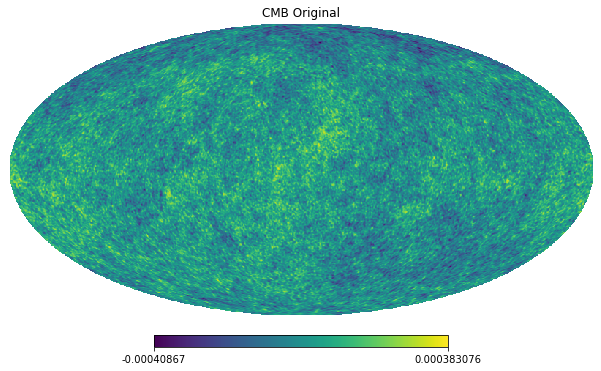

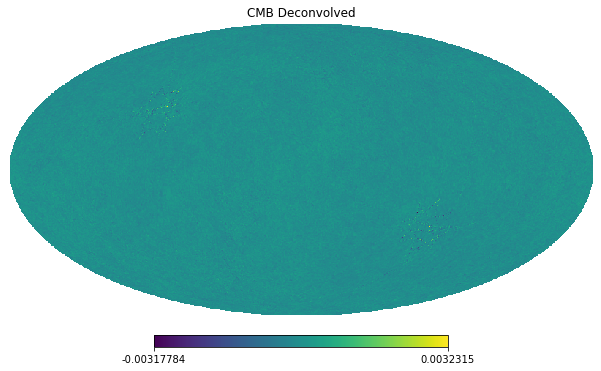

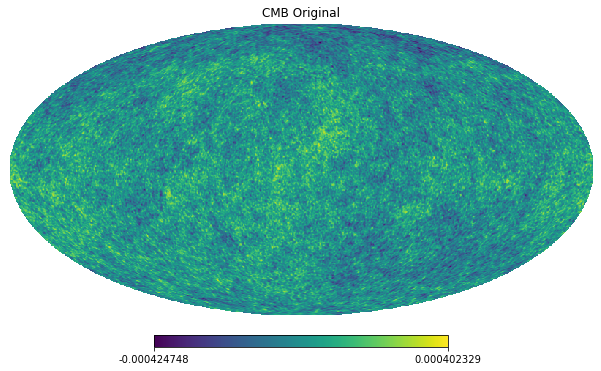

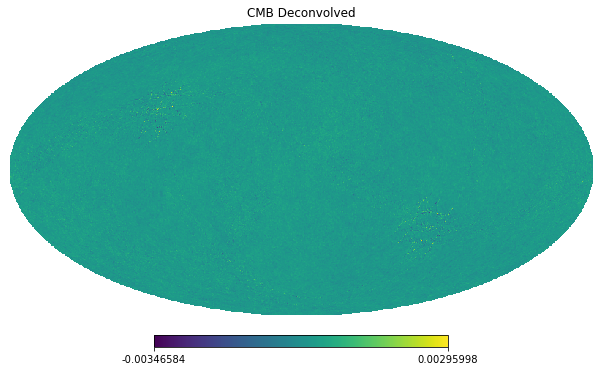

In [8]:
# Define frequencies and realizations
# frequencies = ["030", "044", "070", "100", "143", "217", "353", "545", "857"]
frequencies = ["030", "044"]

realizations = list(range(1))  # Realizations from 0 to 9

# Example usage with user-defined lmax
process_and_save_all_maps(frequencies, realizations, lmax=32)

In [ ]:
#  beam_fwhm = {"030": 32.33, "044": 27.01, "070": 13.25}

#     for frequency in frequencies:
#         for realization in realizations:
#             print(f"Processing maps for frequency {frequency} and realization {realization}")

#             # Define file paths
#             cmb_file = f"{directory}/febecop_ffp10_lensed_scl_cmb_{frequency}_mc_{realization:04d}.fits"
#             synchrotron_file = f"{directory}/COM_SimMap_synchrotron-ffp10-skyinbands-{frequency}_2048_R3.00_full.fits"
#             noise_file = f"{directory}/ffp10_noise_{frequency}_full_map_mc_{realization:05d}.fits"
            
#             # Read maps
#             cmb = read_healpix_map(cmb_file, frequency)
#             hp.mollview(cmb, title="CMB Original")
            
#             nside = hp.get_nside(cmb)
#             lmax = nside * 2
#             cmb_alm = hp.map2alm(cmb, lmax=lmax)
#             fwhm_rad = arcmin_to_radians(5)
#             standard_bl = hp.sphtfunc.gauss_beam(fwhm_rad, lmax=lmax, pol=False)
#             pixwin = hp.sphtfunc.pixwin(nside, lmax=lmax, pol=False)
            
#             # Determine the beam function
#             if frequency in beam_fwhm:
#                 fwhm_rad = arcmin_to_radians(beam_fwhm[frequency])
#                 bl = hp.sphtfunc.gauss_beam(fwhm_rad, lmax=lmax-1, pol=False)
#             else:
#                 # Open the FITS file for custom beam
#                 hfi = fits.open(f"../../CMB_plot/BeamWf_HFI_R3.01/Bl_T_R3.01_fullsky_{frequency}x{frequency}.fits")
#                 bl = hfi[1].data["TEMPERATURE"]
            
#             # Perform deconvolution
#             new_cmb_alm = deconvolve_map(cmb_alm, bl, pixwin, standard_bl)
#             cmb_deconvolved = hp.alm2map(new_cmb_alm, nside=nside)
            
#             # Save the deconvolved map
#             np.save(f"{directory}/febecop_ffp10_lensed_scl_cmb_{frequency}_mc_{realization:04d}.fits", cmb_deconvolved)
#             hp.mollview(cmb_deconvolved, title="CMB Deconvolved")


In [ ]:
def deconvolve_map(cmb_alm, beam, pixwin, standard_bl):
    """
    Deconvolves a spherical harmonic map (alm) by removing the effects of the beam and pixel window functions.

    Args:
        cmb_alm (numpy.ndarray): The input alm array representing the map in spherical harmonics.
        beam (numpy.ndarray): The beam function to be deconvolved (1D array).
        pixwin (numpy.ndarray): The pixel window function to be deconvolved (1D array).
        standard_bl (numpy.ndarray): The standard beam function for reapplying the beam.

    Returns:
        numpy.ndarray: The deconvolved alm array.
    """
    # Beam deconvolution
    deconvolved_alm = hp.almxfl(cmb_alm, 1 / beam)
    
    # Pixel window deconvolution
    deconvolved_alm = hp.almxfl(deconvolved_alm, 1 / pixwin)
    
    # Reapply the standard beam function
    deconvolved_alm = hp.almxfl(deconvolved_alm, standard_bl)
    
    return deconvolved_alm